In [1]:
from PIL import Image
from torchvision import transforms

import matplotlib.pyplot as plt

import tifffile

from time import time
import numpy as np

from utils import *

# Pre trained VGG 19 
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Image Style Transfer Using Convolutional Neural Networks

## 0. Preparations

Leon A. Gatys, Alexander S. Ecker & Matthias Bethge. (2016). Image Style Transfer Using Convolutional Neural Networks. [Downloadable here](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)

In [2]:
# Set default parameters for pyplot
plt.rcParams['figure.figsize'] = [17.0, 8.0]

# Notebook constants
TEXTURE_IMAGE_PATH = "Data/picasso.jpg"
CONTENT_IMAGE_PATH = "Data/tomhardy.jpg"
CNOISE_IMAGE_PATH = "Data/content_noise.jpg"
TNOISE_IMAGE_PATH = "Data/texture_noise.jpg"

Explain goal : transfer the style from texture_image onto content_image. 

### 0.1 The data


We will use a picture of Tom Hardy as the content image and a painting of Kandinsky as the texture image/

In [10]:
content_image = Image.open(CONTENT_IMAGE_PATH)
content_w, content_h = content_image.size
print("Content image loaded; shape =", content_image.size)

texture_image = Image.open(TEXTURE_IMAGE_PATH)
texture_w, texture_h = texture_image.size
print("Texture image loaded; shape =", texture_image.size)

Content image loaded; shape = (600, 900)
Texture image loaded; shape = (2000, 1393)


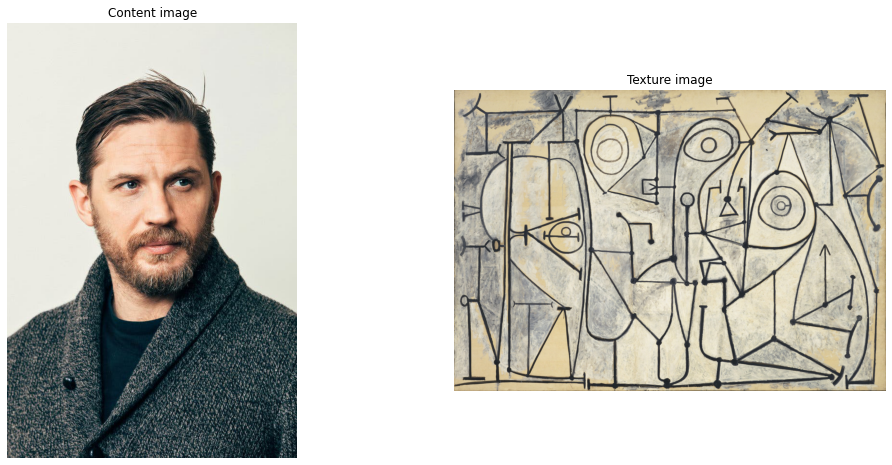

In [11]:
plt.subplot(1, 2, 1)
imshow_noaxis(content_image, title = 'Content image')
plt.subplot(1, 2, 2)
imshow_noaxis(texture_image, title = 'Texture image')
plt.show()

### 0.2 The network

Download pre trained VGG 19 model which will serve to extract features from the images. We remove its classification part and use the remaining network as a feature extractor on our image.

In [12]:
# Get Model
vgg19 = models.vgg19(pretrained = True)

# Remove avg pool and classification part
vgg19_features = vgg19.features

# Check which layers are convolutional layers
index = 0
conv_layer_indices = []

for module in vgg19_features:
    if isinstance(module, nn.modules.conv.Conv2d):
        conv_layer_indices.append(index)
    index+=1
    
print("The model has conv layers at following indices :\n", conv_layer_indices)

The model has conv layers at following indices :
 [0, 2, 5, 7, 10, 12, 14, 16, 19, 21, 23, 25, 28, 30, 32, 34]


There are some helper functions to manipulate tensors and visualize them in the utils.py file. We also create functions to generate white noise images which are used to illustrate the content representation and style representation sections.

In [13]:
create_and_save_white_noise_image(content_w, content_h, CNOISE_IMAGE_PATH)
create_and_save_white_noise_image(texture_w, texture_h, TNOISE_IMAGE_PATH)

## 1. Content reconstruction

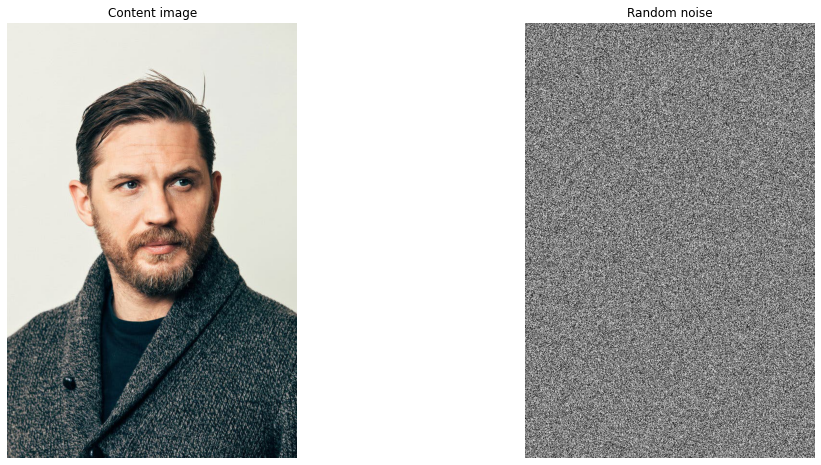

In [15]:
noise_image = Image.open(CNOISE_IMAGE_PATH)

plt.subplot(1, 2, 1)
imshow_noaxis(content_image, title = 'Content image')
plt.subplot(1, 2, 2)
imshow_noaxis(noise_image, title = 'Random noise')
plt.show()

Given a **content image $p$** and a generated **white noise image $x$**, we examine the feature maps generated by the different convolutional layers of the pre-trained network VGG19. For the layer $l$, we denote $N_l$ the number of feature maps and $M_l$ their size (height $*$ weigth of the feature map). Thus, the responses of the layer $l$ for the image $P$ can be stored in a $N_l * M_l$ matrix $P^l$ where $P^l_{ij}$ is the activation of the $i^{th}$ filter at position $j$ in layer $l$. This matrix is referred to as the feature representation of the input image at layer $l$.

Given $P^l$ and $F^l$, the feature representations of respectively $p$ and $x$, the content loss is defined as $\frac{1}{2}\sum_{i,j}(F^l_{ij} - P^l_{ij})^2$.

 We are seeking to minimize this quantity to gradient descent, by updating the values of the initial image $x$ "until it generates the same response in a certain layer of the
Convolutional Neural Network as the original image $p$."

In [9]:
target_image = pil_image_to_torch_tensor(content_image)
#cr_model = ContentRepresentation(vgg19_features[:3], target_image)
optimizer = optim.SGD(cr_model.parameters(), lr = 0.01)

In [10]:
input_image = pil_image_to_torch_tensor(noise_image)
input_image.requires_grad_(True)

for i in np.arange(100):
    
    
    print(input_image.grad, input_image.requires_grad)
    output = cr_model(input_image)
    output.backward()
    print(input_image.grad, input_image.requires_grad)
    
    input_image=input_image - (0.01*input_image.grad)
    print(input_image)
    
    loss = output.item()
    print(input_image.grad, input_image.requires_grad)
    if (i % 20 == 0):
            print(str(i) + " : " + str(loss))

None True
tensor([[[[ 3.7392e-06,  1.0516e-05,  1.5988e-05,  ...,  1.1171e-05,
            1.2025e-05,  1.6481e-05],
          [-1.2770e-05, -9.3504e-06,  2.0834e-05,  ...,  2.4111e-05,
            3.3036e-06, -1.1022e-05],
          [-5.6965e-06, -3.6909e-05, -3.8057e-05,  ..., -8.9633e-06,
           -4.4968e-05, -3.7726e-05],
          ...,
          [ 2.0857e-05,  2.9451e-05,  2.0561e-05,  ...,  2.8552e-05,
            2.8617e-05, -1.4444e-05],
          [ 2.9940e-06,  1.7862e-05,  8.7201e-05,  ...,  7.9733e-07,
            5.5788e-05,  1.1830e-05],
          [-2.6775e-05, -3.3201e-05,  4.2708e-05,  ..., -4.5760e-05,
            7.4099e-06,  1.3401e-05]],

         [[ 3.8011e-07,  1.5923e-05,  2.5887e-05,  ...,  2.4044e-05,
            2.3250e-05,  2.2612e-05],
          [-2.6830e-05, -2.0252e-05,  2.7098e-05,  ...,  4.1022e-05,
            5.5978e-06, -1.9486e-05],
          [-1.2392e-05, -6.2848e-05, -6.3565e-05,  ..., -1.6505e-05,
           -7.6647e-05, -6.8202e-05],
          

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [55]:
print(output)

tensor(0.3568, grad_fn=<MseLossBackward>)


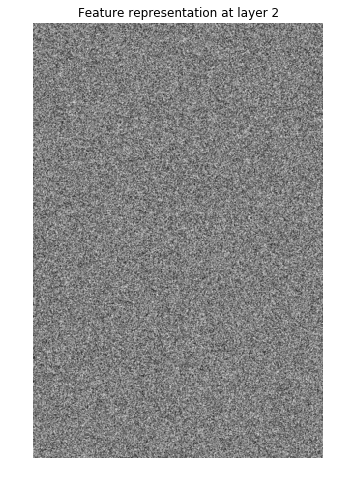

In [54]:
display_tensor_image(input_image, title = 'Feature representation at layer ' + str(conv_layer_index))

In [16]:
def get_content_representation(full_network, 
                               last_conv_index, 
                               content_image, 
                               noise_image, 
                               learning_rate = 0.001, 
                               n_iter = 100):
    
    network = full_network[:last_conv_index + 1]
    
    p = pil_image_to_torch_tensor(content_image)
    x = pil_image_to_torch_tensor(noise_image)
    
    losses = []
    t = time()
    
    for iteration in np.arange(n_iter):
        
        x_old = x.detach()
        x_old.requires_grad_(True)

        p_fmaps = network(p)
        x_fmaps = network(x_old)
        
        loss = content_loss(x_fmaps, p_fmaps)
        losses.append(loss.item())
        
        loss.backward()

        x = x_old - learning_rate * x_old.grad
        
        if (iteration % 10 == 0):
            print(str(iteration) + " " + str(loss.item()), end = ', ')
            
    print("Done in %.2f seconds" %(time() - t))
    
    return x, losses

Now for each convolutional layer we can apply gradient descent to update $x$ untill it matches the feature representation of the content image.

In [17]:
print(conv_layer_indices)

[0, 2, 5, 7, 10, 12, 14, 16, 19, 21, 23, 25, 28, 30, 32, 34]


In [18]:
# Define parameters of run
conv_layer_index = 2
learning_rate = 0.01
n_iter = 150

# Get optimization result
feature_representation, losses = get_content_representation(vgg19_features, 
                                                             conv_layer_index, 
                                                            content_image,
                                                            noise_image, 
                                                            learning_rate,
                                                            n_iter)
 
print("Final loss value : ", losses[-1])

# Save result as tif to avoid loss (since the array is of dtype float)
array_to_save = feature_representation.squeeze(0).permute(1, 2, 0).detach().numpy()
tifffile.imsave("Data/CR_FeatureRepresentationLayer" + str(conv_layer_index) + ".tiff", array_to_save)

# Visualize result (manual error check)
plt.subplot(1, 3, 1)
custom_imshow(content_image, title = 'Input content image')
plt.subplot(1, 3, 2)
display_tensor_image(feature_representation, title = 'Feature representation at layer ' + str(conv_layer_index))
plt.subplot(1, 3, 3)
plt.plot(losses)
plt.title('Content loss evolution')
plt.show()

0 7322723.0, 10 1.1322345637543097e+32, 

KeyboardInterrupt: 